# CoA H+T Costs VS CNT H+T Costs

### Preparation: import package

In [1]:
# a handy trick to get rid of deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from configparser import ConfigParser
import matplotlib.pyplot as plt
import pandas as pd
from census import Census
from us import states
import pyproj
import geopandas as gpd
import numpy as np
import math
import platform
import datetime
import sys
import os
import subprocess
#import seaborn as sb

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.path import Path
import matplotlib.patheffects as PathEffects
from matplotlib import patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import palettable.matplotlib as mplpal
import palettable.colorbrewer.sequential as mplpals
from legendgram import legendgram
import mapclassify # used for reproducing the group of data in natural breaks
%matplotlib inline


### Preparation: updated stored files or links

In [3]:
# Read all environment variables
config = ConfigParser()
config.readfp(open(r'Config.py'))

tx_state = config.get('General',"tx_state") #tx_state shapefile
tx_county  = config.get('General',"tx_county") # tx_county shapefile
tx_bgs = config.get('General',"tx_bgs") # tx_bgs shapefile

coa_ht = config.get('HTcosts',"coa_ht_costs") # import COA h_t index
cnt_ht= config.get('HTcosts',"cnt_ht_costs") # import CNT h_t index


In [4]:
#Read our H+T index

H_Tcost =pd.read_csv (coa_ht)

In [5]:
###Read CNT index
cnt =pd.read_csv (cnt_ht)

In [6]:
# Access shapefile of Texas state
tx_state = gpd.read_file(tx_state) 

# Access shapefile of Texas county
tx_county = gpd.read_file(tx_county)

# Access shapefile of Texas census block groups
tx_bgs = gpd.read_file(tx_bgs)

## A. Load H+T Index of both CoA and CNT

In [7]:
cnt['blkgrp']=cnt['blkgrp'].astype(str).str.strip(' " " ')# remove the quotation mark from blkgrp column

cnt = cnt [['blkgrp','vmt_per_hh_ami','auto_ownership_cost_ami','vmt_cost_ami','transit_cost_ami','t_cost_ami','h_cost','median_smoc','median_gross_rent'] ]# keep necessary variables

cnt ['h_t_ami'] = cnt ['t_cost_ami'] + cnt ['h_cost']*12

In [8]:
cnt

,blkgrp,vmt_per_hh_ami,auto_ownership_cost_ami,vmt_cost_ami,transit_cost_ami,t_cost_ami,h_cost,median_smoc,median_gross_rent,h_t_ami
0,480279800031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,480279800011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,480291417002,25872.0,11982.0,3399.0,0.0,15380.0,1384.0,1401.0,1153.0,31988.0
3,480990104004,26662.0,11940.0,3503.0,4.0,15447.0,652.0,NaN,652.0,23271.0
4,480359504002,24935.0,11975.0,3276.0,2.0,15253.0,1152.0,1230.0,758.0,29077.0
...,...,...,...,...,...,...,...,...,...,...
15794,484410121001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15795,480850306042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15796,484659800001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15797,481130140021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Merge Our index and CNT index

In [9]:
cnt.blkgrp = cnt.blkgrp.astype(str) #convert data type
H_Tcost.geoid = H_Tcost.geoid.astype(str) #convert data type

H_Tcost = H_Tcost.merge (cnt,how = 'left', left_on = 'geoid', right_on = 'blkgrp')
H_Tcost['hh'] = H_Tcost['hh'].fillna(0)
H_Tcost = H_Tcost.fillna(0)
H_Tcost.replace(np.inf, 0, inplace=True)


## B. Mapping for comparison

Mapping Preparation (import shapefile from tiger)

In [10]:
### State's Shapfile ###
# Access shapefile of Texas state, reproject shapefile to the EPSG identifier of NAD83
tx_state  = tx_state.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_state  = tx_state [['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_state.columns= tx_state.columns.str.lower()


# narrow down to TX state

state = ['48']
tx_state   = tx_state [tx_state ['geoid'].isin(state)] 

tx_state ['namelsad'] = tx_state ['name'] # in order to plotting the names


### County's Shapfile ###
# Access shapefile of Texas county, reproject shapefile to the EPSG identifier of NAD83
tx_county = tx_county.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_county = tx_county[['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_county.columns= tx_county.columns.str.lower()


# narrow down to CAMPO county

county = ['48021', '48053', '48055','48209','48453','48491']
campo_county = tx_county[tx_county['geoid'].isin(county)]
campo_county.reset_index(drop=True, inplace=True)

campo_county ['namelsad'] = campo_county ['name'] # in order to plotting the names


### Block groups' Shapfile ###
# Access shapefile of Texas census block groups, reproject shapefile to the EPSG identifier of NAD83
tx_bgs = tx_bgs.to_crs(epsg = 4269)

#clean data through keeping only necessary variables

tx_bgs = tx_bgs[['GEOID', 'ALAND','geometry']]

# rename  columns to lower case
tx_bgs.columns= tx_bgs.columns.str.lower()

# merge shapefile and H+T cost dataframe
tx_bgs.geoid = tx_bgs.geoid.astype(str)
H_Tcost.geoid = H_Tcost.geoid.astype(str)


H_Tcost = tx_bgs.merge(H_Tcost, on = "geoid")
H_Tcost = H_Tcost.drop(columns = {'aland'})


#### Combined H+T Costs

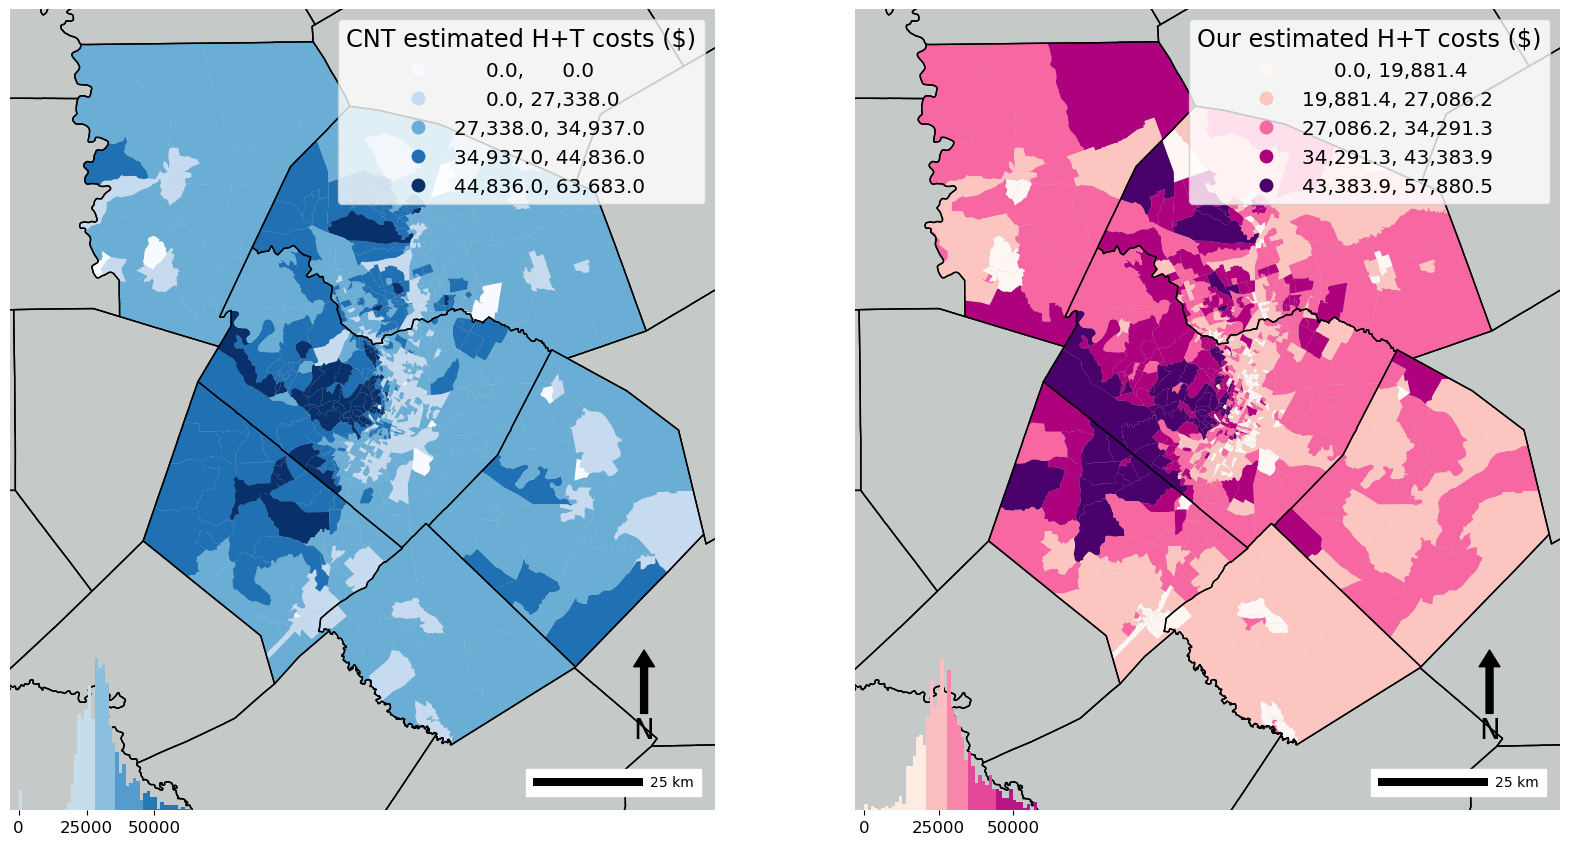

In [11]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15))

ax[0].axis([-98.6,-97,29.5,31.1])
ax[1].axis([-98.6,-97,29.5,31.1])


#####CNT
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)

H_Tcost.plot(column = "h_t_ami",
            ax=ax[0],
            cmap = "Blues",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[0].get_legend().set_title("CNT estimated H+T costs ($)",prop={'size':'xx-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)


ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.h_t_ami, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[0], # the axis to add the legend
           y = H_Tcost.h_t_ami, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.Blues_5, # the palette to use
          )


######OUR INDEX ###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)

H_Tcost.plot(column = "combined H+T",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].get_legend().set_title("Our estimated H+T costs ($)",prop={'size':'xx-large'}) # add legend title


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)


ax[1].axis('off') #Get rid of grids, and x/y axis



# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost['combined H+T'], k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[1], # the axis to add the legend
           y = H_Tcost['combined H+T'], # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/COA_CNT.png')

#### Transit Use

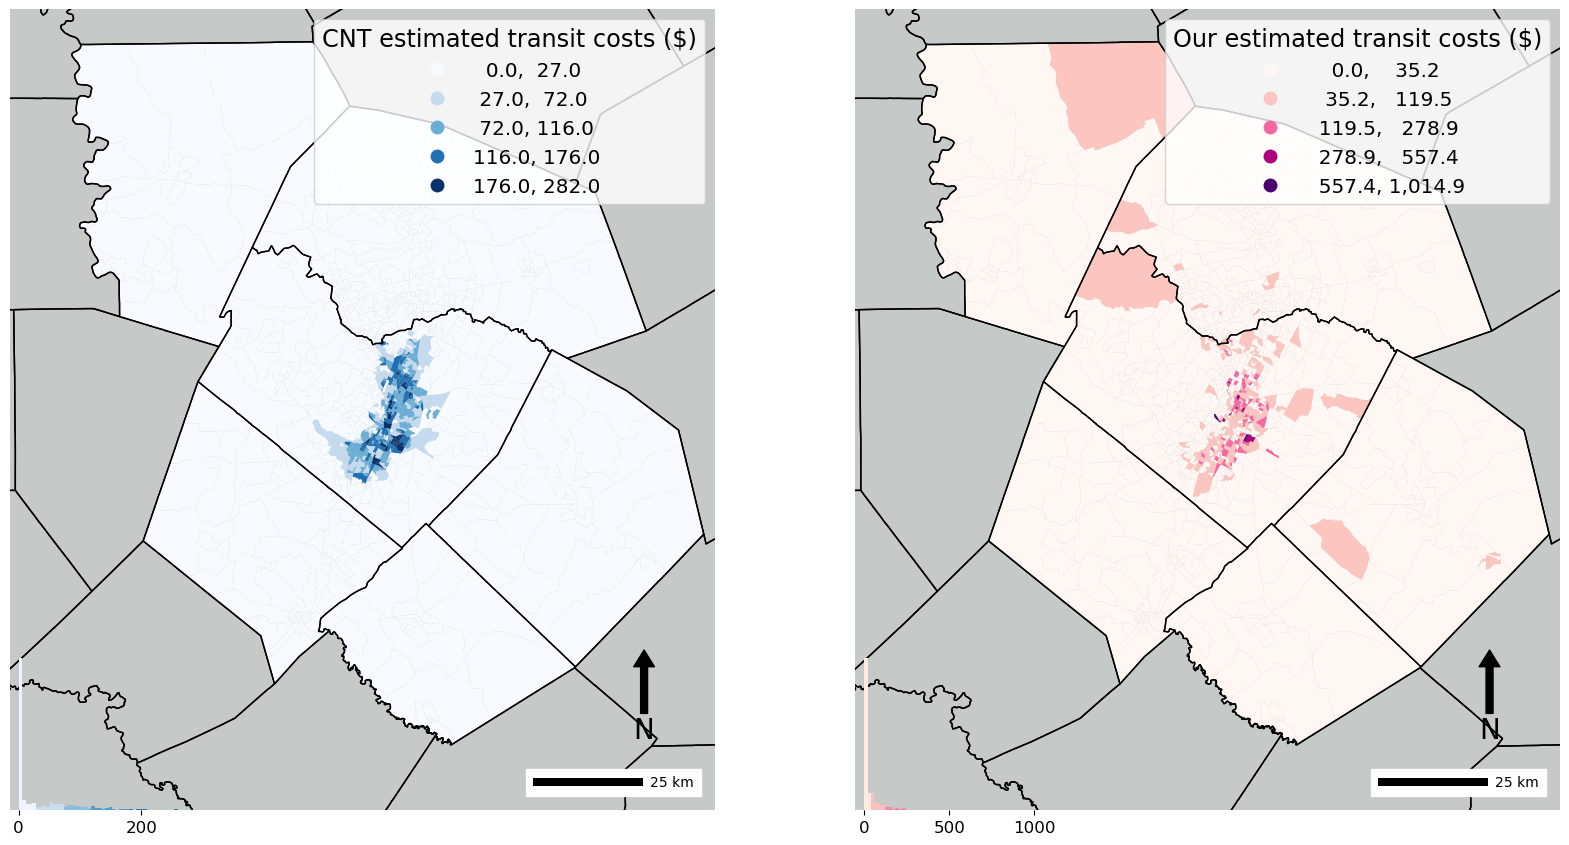

In [12]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15))

ax[0].axis([-98.6,-97,29.5,31.1])
ax[1].axis([-98.6,-97,29.5,31.1])


#####CNT##########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)

H_Tcost.plot(column = "transit_cost_ami",
            ax=ax[0],
            cmap = "Blues",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),       
            zorder = 1)

ax[0].get_legend().set_title("CNT estimated transit costs ($)",prop={'size':'xx-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)


ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.transit_cost_ami, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[0], # the axis to add the legend
           y = H_Tcost.transit_cost_ami, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.Blues_5, # the palette to use
          )


######OUR INDEX ###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)

H_Tcost.plot(column = "transitcost_hh",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].get_legend().set_title("Our estimated transit costs ($)",prop={'size':'xx-large'}) # add legend title


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)


ax[1].axis('off') #Get rid of grids, and x/y axis



# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.transitcost_hh, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[1], # the axis to add the legend
           y = H_Tcost.transitcost_hh, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/COA_CNT_transit.png')

#### Auto-ownership expense

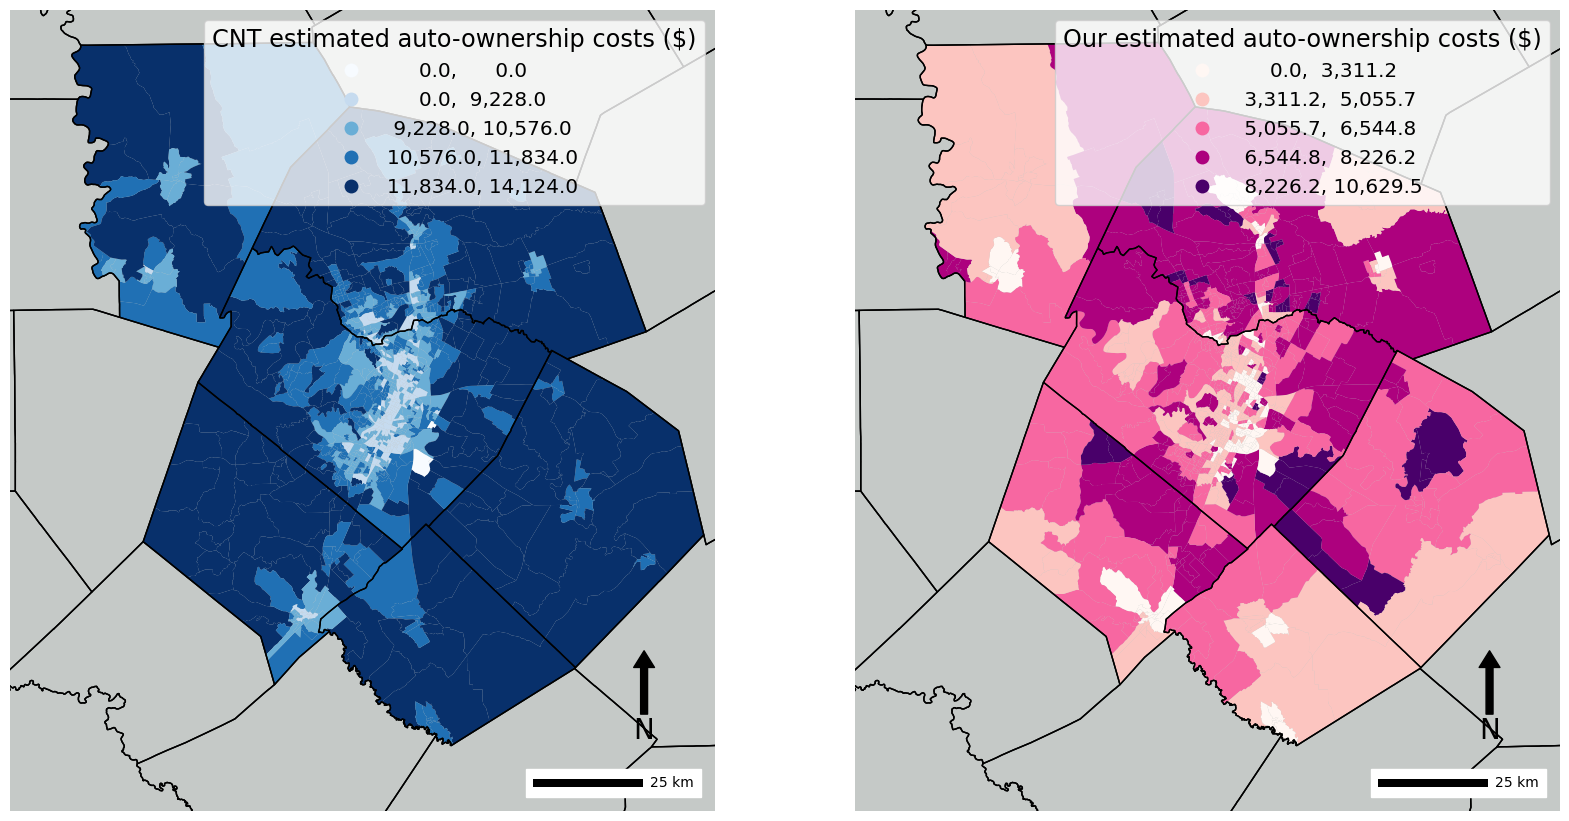

In [13]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15))

ax[0].axis([-98.6,-97,29.5,31.1])
ax[1].axis([-98.6,-97,29.5,31.1])


#####CNT###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)

H_Tcost.plot(column = "auto_ownership_cost_ami",
            ax=ax[0],
            cmap = "Blues",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[0].get_legend().set_title("CNT estimated auto-ownership costs ($)",prop={'size':'xx-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)


ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)




######OUR INDEX ###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)

H_Tcost.plot(column = "carownership_expense_hh",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].get_legend().set_title("Our estimated auto-ownership costs ($)",prop={'size':'xx-large'}) # add legend title


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)


ax[1].axis('off') #Get rid of grids, and x/y axis



# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)



fig.savefig('images/COA_CNT_auto-ownership.png')

#### Total Transportation Cost

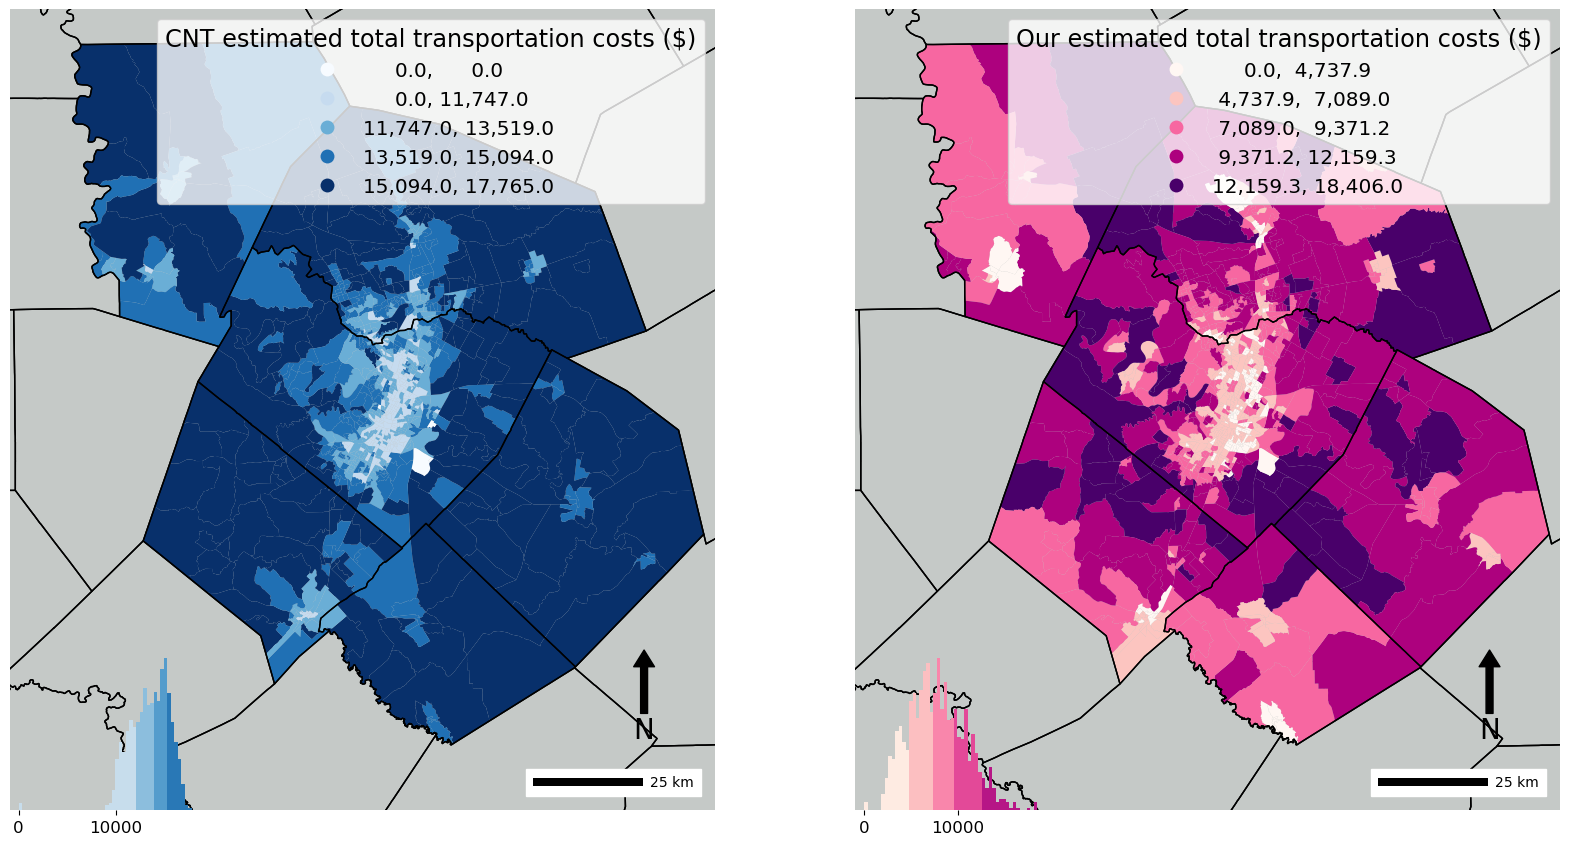

In [14]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15))

ax[0].axis([-98.6,-97,29.5,31.1])
ax[1].axis([-98.6,-97,29.5,31.1])


#####CNT##########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)

H_Tcost.plot(column = "t_cost_ami",
            ax=ax[0],
            cmap = "Blues",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[0].get_legend().set_title("CNT estimated total transportation costs ($)",prop={'size':'xx-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)


ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.t_cost_ami, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[0], # the axis to add the legend
           y = H_Tcost.t_cost_ami, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.Blues_5, # the palette to use
          )


######OUR INDEX ###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)

H_Tcost.plot(column = "Transportation_Cost",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].get_legend().set_title("Our estimated total transportation costs ($)",prop={'size':'xx-large'}) # add legend title


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)


ax[1].axis('off') #Get rid of grids, and x/y axis



# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.Transportation_Cost, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[1], # the axis to add the legend
           y = H_Tcost.Transportation_Cost, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/COA_CNT_tot_transportationcosts.png')

#### Housing Cost

##### Total average monthly housing costs (housing-owner costs)

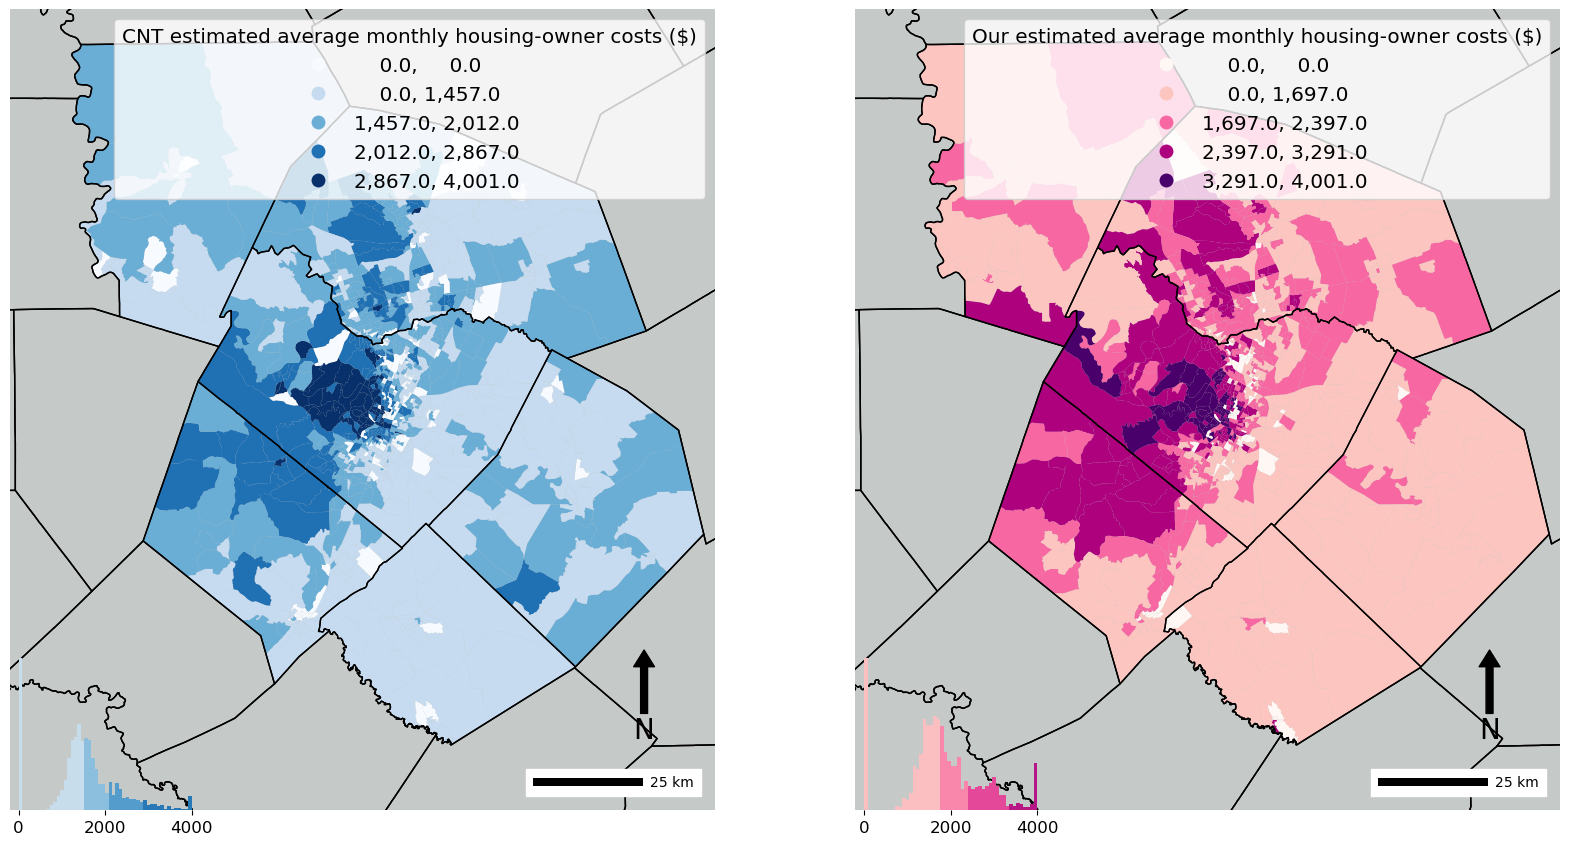

In [15]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15))

ax[0].axis([-98.6,-97,29.5,31.1])
ax[1].axis([-98.6,-97,29.5,31.1])


#####CNT###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)

H_Tcost.plot(column = "median_smoc",
            ax=ax[0],
            cmap = "Blues",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[0].get_legend().set_title("CNT estimated average monthly housing-owner costs ($)",prop={'size':'x-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)


ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.median_smoc, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[0], # the axis to add the legend
           y = H_Tcost.median_smoc, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.Blues_5, # the palette to use
          )


######OUR INDEX ###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)

H_Tcost.plot(column = "housing_mortgage_monthly",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].get_legend().set_title("Our estimated average monthly housing-owner costs ($)",prop={'size':'x-large'}) # add legend title


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)


ax[1].axis('off') #Get rid of grids, and x/y axis



# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.housing_mortgage_monthly, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[1], # the axis to add the legend
           y = H_Tcost.housing_mortgage_monthly, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/COA_CNT_monthly_housing_ownercosts.png')

##### Total average monthly housing costs (renter costs)

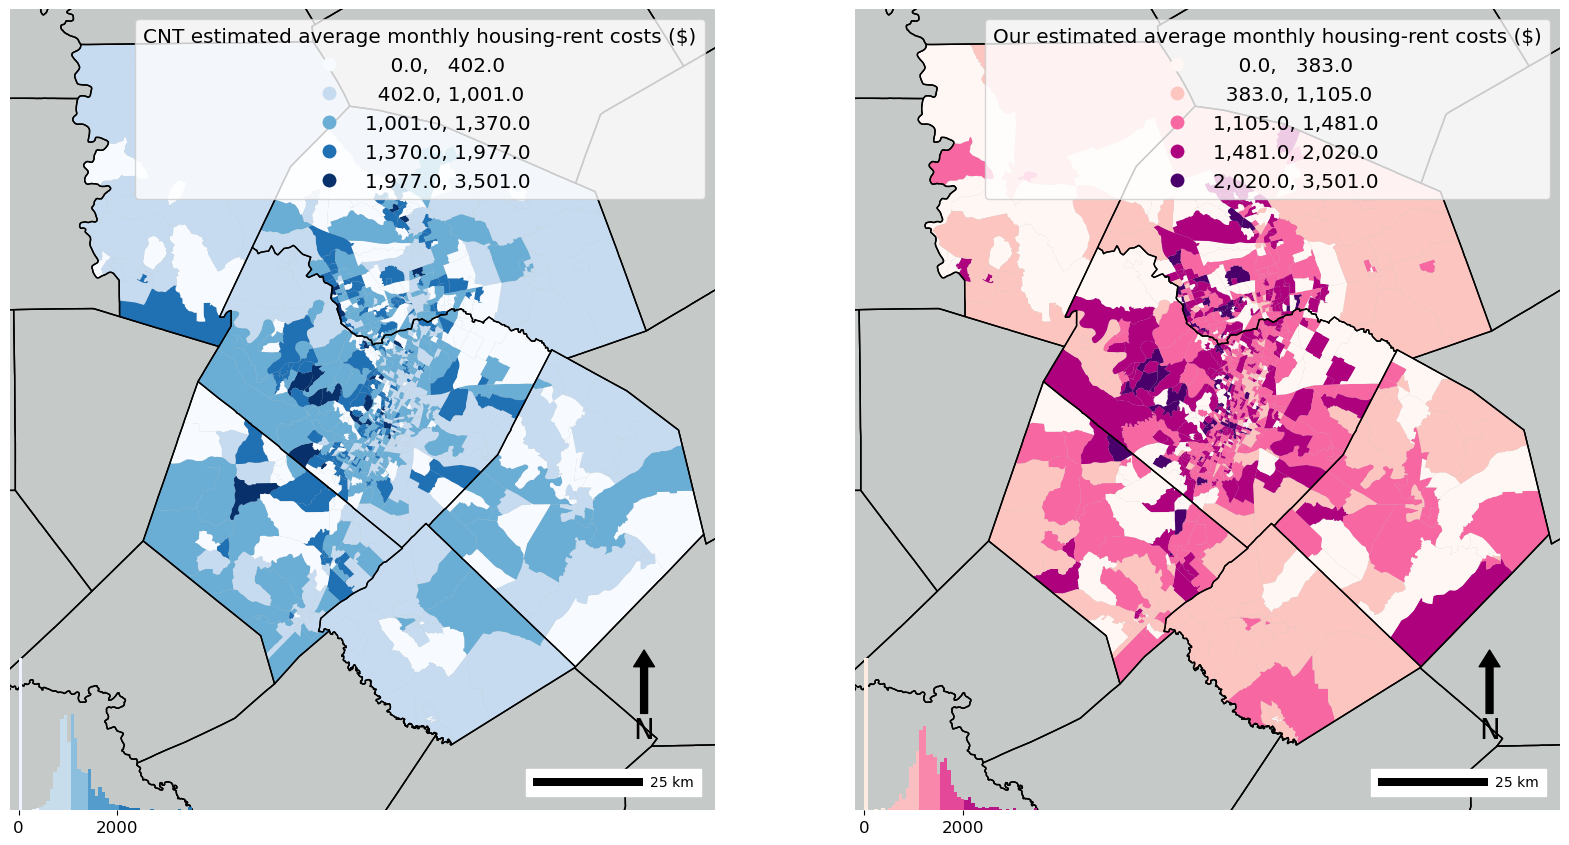

In [16]:
# Create two geopandas maps side by side

fig, ax= plt.subplots(ncols=2, figsize=(20, 15))

ax[0].axis([-98.6,-97,29.5,31.1])
ax[1].axis([-98.6,-97,29.5,31.1])


#####CNT#########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax[0], zorder=2)

H_Tcost.plot(column = "median_gross_rent",
            ax=ax[0],
            cmap = "Blues",
            scheme='natural_breaks',
            k=5,
            legend = True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[0].get_legend().set_title("CNT estimated average monthly housing-rent costs ($)",prop={'size':'x-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[0], zorder=0)


ax[0].axis('off') #Get rid of grids, and x/y axis


# add scalre bar
ax[0].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.median_gross_rent, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[0], # the axis to add the legend
           y = H_Tcost.median_gross_rent, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.Blues_5, # the palette to use
          )


######OUR INDEX ###########
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax = ax[1], zorder=2)

H_Tcost.plot(column = "housing_rent_monthly",
            ax=ax[1],
            cmap = "RdPu",
            scheme='natural_breaks',
            k=5,
            legend= True,
            legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")),
            zorder = 1)

ax[1].get_legend().set_title("Our estimated average monthly housing-rent costs ($)",prop={'size':'x-large'}) # add legend title


tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax=ax[1], zorder=0)


ax[1].axis('off') #Get rid of grids, and x/y axis



# add scalre bar
ax[1].add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax[1].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[1].transAxes)


## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=H_Tcost.housing_rent_monthly, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax[1], # the axis to add the legend
           y = H_Tcost.housing_rent_monthly, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

fig.savefig('images/COA_CNT_monthly_housing_rentcosts.png')